In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from time import time
import numpy as np

/var/folders/4b/f86rqqqj3rg8vczy4jw34t6r0000gn/T/ipykernel_7303/937558388.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# get features and labels
data = pd.read_pickle('pifsc_embeddings2.pickle')
features = dict(data)
data = pd.read_pickle('pifsc_embeddings.pkl')
features.update(data)

cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [3]:
# clean labels
is_na = labels.distinctiveness.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
# labels.reset_index(drop=False, inplace=True)

# clean features
imgs = labels.image.tolist()
features = {k: v for k, v in features.items() if k in imgs}
assert len(features) == len(labels)

In [4]:
# binary labeling
print(labels.distinctiveness.value_counts())
for index, row in labels.iterrows():
    if row.distinctiveness == 2:
        labels.at[index, 'distinctiveness'] = 1
    if row.distinctiveness == 4 or row.distinctiveness == 3:
        labels.at[index, 'distinctiveness'] = 0
print(labels.distinctiveness.value_counts())

distinctiveness
2.0    2343
1.0    1152
3.0      44
4.0      37
Name: count, dtype: int64
distinctiveness
1.0    3495
0.0      81
Name: count, dtype: int64


In [5]:
# get data, split
Y = labels.distinctiveness
X = np.array([features[i] for i in labels.image])
# species = labels.species.astype('category').cat.codes
# X = np.insert(X, 0, species, axis=1)
sc = StandardScaler()
X = sc.fit_transform(X)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [6]:
clf = SVC(class_weight='balanced', random_state=42, kernel='poly', degree=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for clf in classifiers:
#     clf.fit(X_train, Y_train)

In [7]:
pred = cross_val_predict(clf, X, Y, n_jobs=-1, cv=cv)
print(f'deg={clf.degree}'.center(53, '-'))
print(classification_report(Y, pred))

------------------------deg=2------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.63      0.71        81
         1.0       0.99      1.00      0.99      3495

    accuracy                           0.99      3576
   macro avg       0.91      0.81      0.85      3576
weighted avg       0.99      0.99      0.99      3576



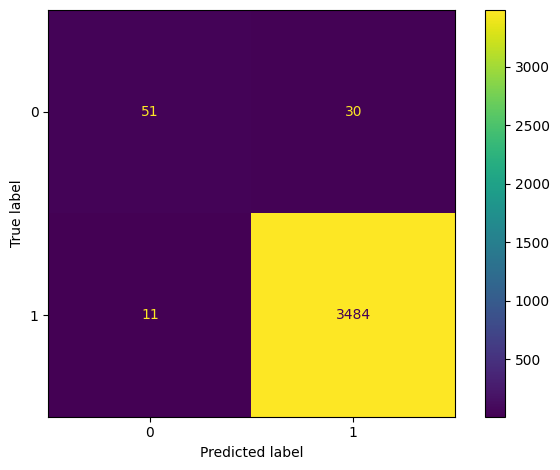

In [10]:
# results
# fig, axes = plt.subplots(1, 2)
# for i, (clf, ax) in enumerate(zip(classifiers, axes.flatten())):
cm = confusion_matrix(Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [9]:
print(Y.value_counts())

distinctiveness
1.0    3495
0.0      81
Name: count, dtype: int64
